# Financial Engineering - Instrument Analysis

###### Andrew Cachia, Dec 2018

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt  
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
from scipy.optimize import minimize
from scipy.special import ndtri
from scipy.stats import norm

### Data
Retrieving daily closing price data for the following stocks:
- S&P500 Index [SPY]
- FTSE 100 Index [UKX]
- Gold SPDY [GLD]
- Google [GOOG]
- Amazon [AMZN]

In [2]:
ftse = pd.read_csv('ftse-100.csv', parse_dates=True,index_col=0, date_parser=lambda x: pd.to_datetime(x).strftime("%d/%m/%Y"))
ftse = ftse['FTSE 100']
ftse.head()

Date
2017-12-29    7687.77
2017-12-28    7622.88
2017-12-27    7620.68
2017-12-22    7592.66
2017-12-21    7603.98
Name: FTSE 100, dtype: float64

In [3]:
date_start = "2014-01-01"
date_end = "2017-12-31"

symbols = ['^GSPC','GLD','GOOG','AMZN']

data = pd.DataFrame()
yf.pdr_override() 
data = pdr.get_data_yahoo(symbols, start=date_start, end=date_end)
data.head()

[*********************100%***********************]  4 of 4 downloaded


Open                                             High  \
                  AMZN         GLD        GOOG        ^GSPC        AMZN   
Date                                                                      
2013-12-31  394.579987  114.610001  552.526367  1842.609985  398.829987   
2014-01-02  398.799988  117.930000  554.125916  1845.859985  399.359985   
2014-01-03  398.290009  118.639999  553.897461  1833.209961  402.709991   
2014-01-06  395.850006  119.760002  552.908875  1832.310059  397.000000   
2014-01-07  395.040009  118.459999  558.865112  1828.709961  398.470001   

                                                        Low              \
                   GLD        GOOG        ^GSPC        AMZN         GLD   
Date                                                                      
2013-12-31  117.129997  556.878052  1849.439941  393.799988  114.459999   
2014-01-02  118.730003  555.263550  1845.859985  394.019989  117.750000   
2014-01-03  119.620003  554.856201  1838.239990  396.220001  118.589996   
2014-01-06  120.389999  555.814941  1837.160034  388.420013  117.110001   
2014-01-07  118.919998  566.162659  1840.099976  394.290009  118.129997   

               ...           Close                Adj Close              \
               ...            GOOG        ^GSPC        AMZN         GLD   
Date           ...                                                        
2013-12-31     ...      556.734009  1848.359985  398.790009  116.120003   
2014-01-02     ...      552.963501  1831.979980  397.970001  118.000000   
2014-01-03     ...      548.929749  1831.369995  396.440002  119.290001   
2014-01-06     ...      555.049927  1826.770020  393.630005  119.500000   
2014-01-07     ...      565.750366  1837.880005  398.029999  118.820000   

                                      Volume                                 
                  GOOG        ^GSPC     AMZN       GLD     GOOG       ^GSPC  
Date                                                                         
2013-12-31  556.734009  1848.359985  1996500  12835900  2733400  2312840000  
2014-01-02  552.963501  1831.979980  2137800   7551000  3666400  3080600000  
2014-01-03  548.929749  1831.369995  2210200   5874400  3355000  2774270000  
2014-01-06  555.049927  1826.770020  3170600  10106500  3561600  3294850000  
2014-01-07  565.750366  1837.880005  1916000   6433700  5138400  3511750000  

[5 rows x 24 columns]

In [4]:
data = data['Adj Close']
data['FTSE'] = ftse
data.head()

,AMZN,GLD,GOOG,^GSPC,FTSE
Date,,,,,
2013-12-31,398.790009,116.120003,556.734009,1848.359985,NaN
2014-01-02,397.970001,118.000000,552.963501,1831.979980,6717.91
2014-01-03,396.440002,119.290001,548.929749,1831.369995,6730.67
2014-01-06,393.630005,119.500000,555.049927,1826.770020,6730.73
2014-01-07,398.029999,118.820000,565.750366,1837.880005,6755.45


## Calculating logarithmic returns
We use logarithmic returns as this will allow us to assume that prices are distributed log normally. This is convenient since much of classic statistics assumes log normality. 

In [5]:
returns = data / data.shift(1)
returns = np.log(returns)
returns = returns.dropna()
returns.head()

,AMZN,GLD,GOOG,^GSPC,FTSE
Date,,,,,
2014-01-03,-0.003852,0.010873,-0.007322,-0.000333,0.001898
2014-01-06,-0.007113,0.001759,0.011088,-0.002515,0.000009
2014-01-07,0.011116,-0.005707,0.019095,0.006063,0.003666
2014-01-08,0.009726,-0.005909,0.002079,-0.000212,-0.004997
2014-01-09,-0.002267,0.002874,-0.009677,0.000348,-0.004539


##### Generic Functions

In [6]:
def mean(list):
    return list.sum() / len(list)

def generic_function(X,Y,exp):
    results = {}
    for i in X:
        sum = 0
        for j in X[i]:
            sum += (j - Y[i])**exp
        results[i] = sum / len(X[i])
    
    return results

def variance(list,mean_list):
    return generic_function(list, mean_list, 2)

##### Standard Deviation
Standard Deviation is used to describe the hisotrical volatility of an instrument. 
The greater the standard deviation, the larger the price range and fluctuations.
\begin{equation*}
\sqrt{\frac{\sum(X - \overline{X}) ^2} {N}}
\end{equation*}

In [7]:
def std_dev(list,mean_list):
    var = variance(list,mean_list)
    for i in var:
        var[i] = np.sqrt(var[i])
    return var

##### Skewness
Skewness is used to measure the differnce in the length of the tails, i.e. how symmetrical or not a distribution is.
Negative skewness means there is a substantial probability of a large negative return. 
Positive skewness means that there is a greater-than-normal probability of a large positive return.
Fisher-Pearson coefficient of skewness:
\begin{equation*}
\frac
{\sum\frac{(X - \overline{X})^3}{N} } 
{s^3}
\end{equation*}

In [8]:
def skewness(list,mean_list):
    results = {}
    num = generic_function(list, mean_list, 3)
    list_std_dev = std_dev(list,mean_list)
    for i in list_std_dev:
        list_std_dev[i] = list_std_dev[i]**3
        results[i] = num[i] / list_std_dev[i]
    return results

##### Kurtosis
Kurtosis is used to measure the extreme values within either tail of the distribution.
It is used in finance to determine the likelihood of the investor experiencing extreme positive or negative returns.
\begin{equation*}
\frac
{\sum\frac{(X - \overline{X})^4}{N} } 
{s^4}
\end{equation*}

In [9]:
def kurtosis(list,mean_list):
    results = {}
    num = generic_function(list, mean_list, 4)
    var = variance(list,mean_list)
    for i in var:
        var[i] = var[i]**2
        results[i] = num[i] / var[i]
    return results

##### Annual Volatility

In [10]:
def annualVolatility(volatility_list):
    results = {}
    for i in volatility_list:
        results[i] = (volatility_list[i] * np.sqrt(250))# * 100
        
    return results

### Calculating Distribution Moments

In [11]:
avg_return = mean(returns)
volatility = std_dev(returns, avg_return)
dkurtosis = kurtosis(returns, avg_return)
dskewness = skewness(returns, avg_return)

#annual_return = (avg_return * 250)# * 100
annual_return = (((1 + avg_return)**250 - 1)) # * 100)
annual_volatility = annualVolatility(volatility)

I = pd.Index(["Average Return", "Volatility", "Kurtosis", "Skewness", "Annual Return", "Annual Volatility"])
moments = [avg_return.to_dict(), volatility, dkurtosis, dskewness, annual_return.to_dict(), annual_volatility]
pd.DataFrame(moments, index=I)

,AMZN,FTSE,GLD,GOOG,^GSPC
Average Return,0.000944,0.000164,-0.000010,0.000686,0.000397
Volatility,0.018579,0.008867,0.008811,0.013846,0.007620
Kurtosis,15.184563,5.645759,5.330956,18.595021,6.054978
Skewness,0.414527,-0.113160,0.218417,1.307668,-0.365058
Annual Return,0.265922,0.041971,-0.002429,0.187040,0.104328
Annual Volatility,0.293759,0.140198,0.139309,0.218928,0.120475


From the results shown above, it seems that the GLD was not only the worst perfoming asset, but also that with the highest risk.

The S&P500 index was the highest perfoming in terms of average return, and also managed to remain stable with the lowest volatility.

The S&P 500 had a solid 10.4% annual return, solidfying it's status as the industry benchmark. It also kept a low and stable volatility.

One would expect FTSE and GLD, due to having higher volatility, should also have a higher kurtosis signfiying a higher probability of positive extremes. However, this is not the case and the ^GSPC still managed to generate a higher kurtosis value.

### Price Level Probability

Price level at which there is a 32% chance that the actual price will be above: 2673.63


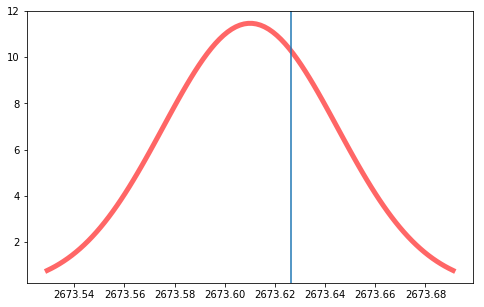

In [18]:
fig, ax = plt.subplots(1, 1,figsize=(8,5))

#Calculate normal distribution using mean S&P500 price, and annual volatility / 12 as the Std Deviation
sp_mean = data['^GSPC'].iloc[-1]
sp_vol = volatility['^GSPC'] * np.sqrt(250/12)
n = norm(sp_mean, sp_vol)
result = n.ppf(1 - 0.32)

#Draw distribution and line at 32%
x = np.linspace(n.ppf(0.01),n.ppf(0.99), 100)
ax.plot(x, n.pdf(x), 'r-', lw=5, alpha=0.6, label='norm pdf')
ax.ticklabel_format(useOffset=False, style='plain')
ax.axvline(x=n.ppf(1 - 0.32))

print("Price level at which there is a 32% chance that the actual price will be above: {0:.2f}".format(result))

##### Covariance
Covariance is a measure of the directional relationship between the returns on two risky assets. A positive covariance means that asset returns move together while a negative covariance means returns move inversely.
\begin{equation*}
\frac{1}{N}\sum_{i=1}^N(X - \overline{X})(Y - \overline{Y})
\end{equation*}

In [ ]:
def covariance(X,Y):
    meanX = mean(X)
    meanY = mean(Y)

    sum = 0

    for i in range(0, len(X)):
        sum += ((X[i] - meanX) * (Y[i] - meanY))

    return sum/(len(X)-1)

##### Beta
Beta is used to determine the sensitivity of a stock's volatility in relation to the market.

\begin{equation*}
\frac{Cov(r_p, r_b)}{Var(r_b)}
\end{equation*}

In [ ]:
def beta(X,Y):
    meanX = mean(X)
    covarianceXY = covariance(X,Y)
    varianceY = sum([(i-meanX)**2 for i in Y]) / len(Y)
    
    return covarianceXY / varianceY

In [ ]:
beta_google = beta(returns['GOOG'],returns['^GSPC'])
beta_amazon = beta(returns['AMZN'],returns['^GSPC'])
print(beta_google)
print(beta_amazon)